<a href="https://colab.research.google.com/github/BernardoRMendes/Projeto/blob/main/FatoresUSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
!pip install yfinance
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Nesse estudo veremos como decompor os retornos de um portfólio de acordo com fatores de risco.**

**Para isso, foi utilizado o modelo de Carhart, com 4 fatores, representando a combinação dos 3 fatores de Fama-French com o Fator de Momentum:**

**Rm-Rf: retorno de mercado menos a taxa livre de risco.**

**SMB: Representa o fator Size (Small Caps - Large Caps)**

**HML: Representa o fator Value (Valor - Crescimento)**

**Mom: Representa o fator Momentum (Ações com maior força relativa - Ações com menor força relativa)**

**Detalhes da metodologia de cada fator:**

http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [2]:
from pandas_datareader.famafrench import get_available_datasets

**Datasets disponíveis para download:**

In [3]:
get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [4]:
ff_dict = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', 
                         start='2019-01-01', end='2020-12-31')
ff_dict2= web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', 
                         start='2019-01-01', end='2020-12-31')

In [5]:
ff_dict.keys()

dict_keys([0, 'DESCR'])

In [6]:
print(ff_dict['DESCR'])

F-F Research Data Factors daily
-------------------------------

This file was created by CMPT_ME_BEME_RETS_DAILY using the 202103 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2021 Kenneth R. French

  0 : (505 rows x 4 cols)


In [7]:
ff_dict[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2019-01-02,0.23,0.56,1.10,0.01
2019-01-03,-2.45,0.40,1.21,0.01
2019-01-04,3.55,0.41,-0.70,0.01
2019-01-07,0.94,0.97,-0.77,0.01
2019-01-08,1.01,0.53,-0.64,0.01


In [8]:
ff_dict=pd.DataFrame(ff_dict[0])

In [9]:
ff_dict2=pd.DataFrame(ff_dict2[0])

In [10]:
ff_dict=ff_dict.join(ff_dict2)

In [11]:
ff_dict

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
2019-01-02,0.23,0.56,1.10,0.01,-2.32
2019-01-03,-2.45,0.40,1.21,0.01,-0.74
2019-01-04,3.55,0.41,-0.70,0.01,-1.03
2019-01-07,0.94,0.97,-0.77,0.01,-0.80
2019-01-08,1.01,0.53,-0.64,0.01,0.16
...,...,...,...,...,...
2020-12-24,0.21,-0.39,-0.17,0.00,0.22
2020-12-28,0.46,-0.72,0.32,0.00,-0.49
2020-12-29,-0.40,-1.52,0.24,0.00,-0.41


**Seleção de ativos, pesos (escolhidos de forma aleatória) e datas:**

In [12]:
ativos= ['NVDA', 'PYPL', 'MSFT','NKE','V','JPM','WMT','PG','JNJ','BA']
pesos=np.random.rand(1,10)
pesos=pesos/pesos.sum()
inicio = '2019-01-01'
fim = '2020-12-31'

In [13]:
pesos

array([[0.20047027, 0.07356187, 0.10558079, 0.04188496, 0.03103446,
        0.07180526, 0.10412513, 0.03493096, 0.19100542, 0.14560087]])

In [14]:
asset_df = yf.download(ativos,start=inicio,end=fim,adjusted=True,progress=False)

print(f'Download de {asset_df.shape[0]} observações.')

Download de 504 observações.


In [15]:
asset_df = asset_df['Adj Close'].resample('D').last().pct_change().dropna()

In [16]:
asset_df

,BA,JNJ,JPM,MSFT,NKE,NVDA,PG,PYPL,V,WMT
Date,,,,,,,,,,
2019-01-03,-0.039869,-0.015890,-0.014212,-0.036788,-0.017688,-0.060417,-0.007011,-0.042682,-0.036036,-0.005143
2019-01-04,0.052042,0.016783,0.036866,0.046509,0.026117,0.064068,0.020410,0.050920,0.043081,0.006246
2019-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-07,0.003149,-0.006415,0.000695,0.001275,0.014333,0.052940,-0.004000,0.007650,0.018032,0.011772
...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-28,-0.004881,0.004722,0.006585,0.009921,0.005861,-0.007215,0.006971,-0.012194,0.018831,0.011986


In [17]:
asset_df['portfolio_retorno'] = np.matmul(asset_df[ativos].values, 
                                          pesos.T)*100
asset_df.head()

,BA,JNJ,JPM,MSFT,NKE,NVDA,PG,PYPL,V,WMT,portfolio_retorno
Date,,,,,,,,,,,
2019-01-03,-0.039869,-0.015890,-0.014212,-0.036788,-0.017688,-0.060417,-0.007011,-0.042682,-0.036036,-0.005143,-3.163591
2019-01-04,0.052042,0.016783,0.036866,0.046509,0.026117,0.064068,0.020410,0.050920,0.043081,0.006246,3.872441
2019-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-07,0.003149,-0.006415,0.000695,0.001275,0.014333,0.052940,-0.004000,0.007650,0.018032,0.011772,1.283954


In [18]:
ff_data = asset_df.join(ff_dict).drop(ativos, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml','rf','mon']
ff_data.dropna(inplace=True)

In [19]:
ff_data

,portf_rtn,mkt,smb,hml,rf,mon
Date,,,,,,
2019-01-03,-3.163591,-2.45,0.40,1.21,0.01,-0.74
2019-01-04,3.872441,3.55,0.41,-0.70,0.01,-1.03
2019-01-07,1.283954,0.94,0.97,-0.77,0.01,-0.80
2019-01-08,0.866835,1.01,0.53,-0.64,0.01,0.16
2019-01-09,0.531235,0.56,0.45,0.09,0.01,-0.85
...,...,...,...,...,...,...
2020-12-23,-0.607053,0.10,0.34,2.00,0.00,-2.17
2020-12-24,0.003271,0.21,-0.39,-0.17,0.00,0.22
2020-12-28,0.168965,0.46,-0.72,0.32,0.00,-0.49


In [20]:
ff_model = smf.ols(formula='portf_rtn ~ mkt + smb + hml+ mon', 
                   data=ff_data).fit()
 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:              portf_rtn   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     1468.
Date:                Tue, 11 May 2021   Prob (F-statistic):          5.71e-274
Time:                        12:17:08   Log-Likelihood:                -389.93
No. Observations:                 503   AIC:                             789.9
Df Residuals:                     498   BIC:                             811.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0174      0.024      0.730      0.4

In [21]:
df=ff_data[['portf_rtn','mkt']]/100
df['Portfolio']=100*(1+df['portf_rtn']).cumprod()
df['Mercado']=100*(1+df['mkt']).cumprod()

In [22]:
df

,portf_rtn,mkt,Portfolio,Mercado
Date,,,,
2019-01-03,-0.031636,-0.0245,96.836409,97.550000
2019-01-04,0.038724,0.0355,100.586342,101.013025
2019-01-07,0.012840,0.0094,101.877825,101.962547
2019-01-08,0.008668,0.0101,102.760937,102.992369
2019-01-09,0.005312,0.0056,103.306839,103.569126
...,...,...,...,...
2020-12-23,-0.006071,0.0010,188.910168,156.038249
2020-12-24,0.000033,0.0021,188.916348,156.365929
2020-12-28,0.001690,0.0046,189.235551,157.085213


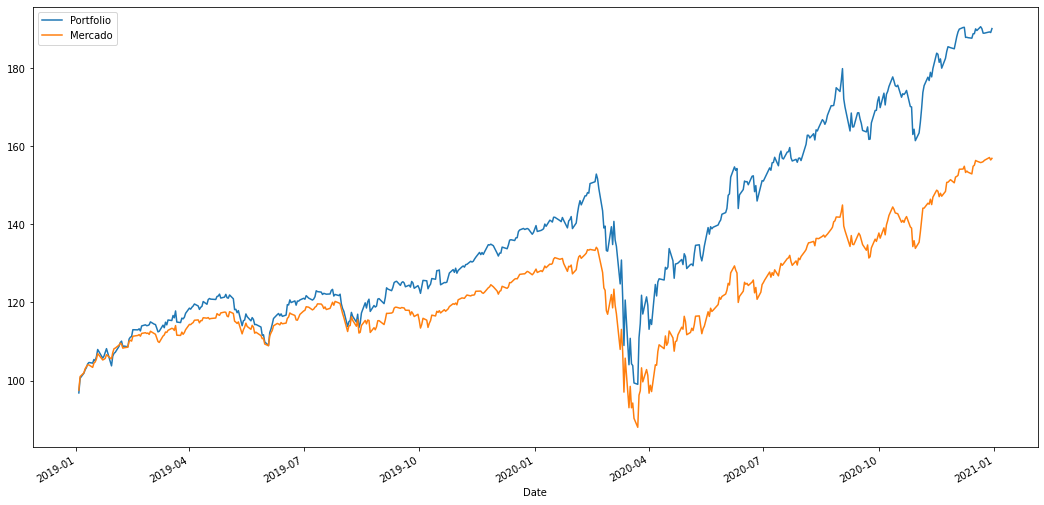

In [23]:
df[['Portfolio','Mercado']].plot(figsize=(18,9))

**Observe que mesmo o Portfólio produzindo retornos acima do Mercado, não podemos dizer que houve geração de alpha, pois o Intercepto não é estatisticamente diferente de zero (considerando um nível de significância de 5%). O retorno do portfólio pode ser explicado pelos fatores de investimento (Beta).**

In [24]:
def rolling_factor_model(input_data, formula, window_size):
    '''
    Função para estimar a exposição aos fatores em janelas móveis de tempo.
    
    Parâmetros
    ------------
    input_data : pd.DataFrame
         DataFrame contendo os fatores e os retornos do portfólio
    formula : str
        `statsmodels` fórmula representando a regressão linear  
    window_size : int
        Comprimento da janela móvel.
    
    Retorna
    -----------
    coeffs_df : pd.DataFrame
        DataFrame contendo o intercepto e os fatores para cada iteração
    '''

    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # Define e faz o fit do modelo
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]
        ).fit()
   
        # Armazena os coeficientes
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

**Para uma janela móvel de 90 dias, temos:**

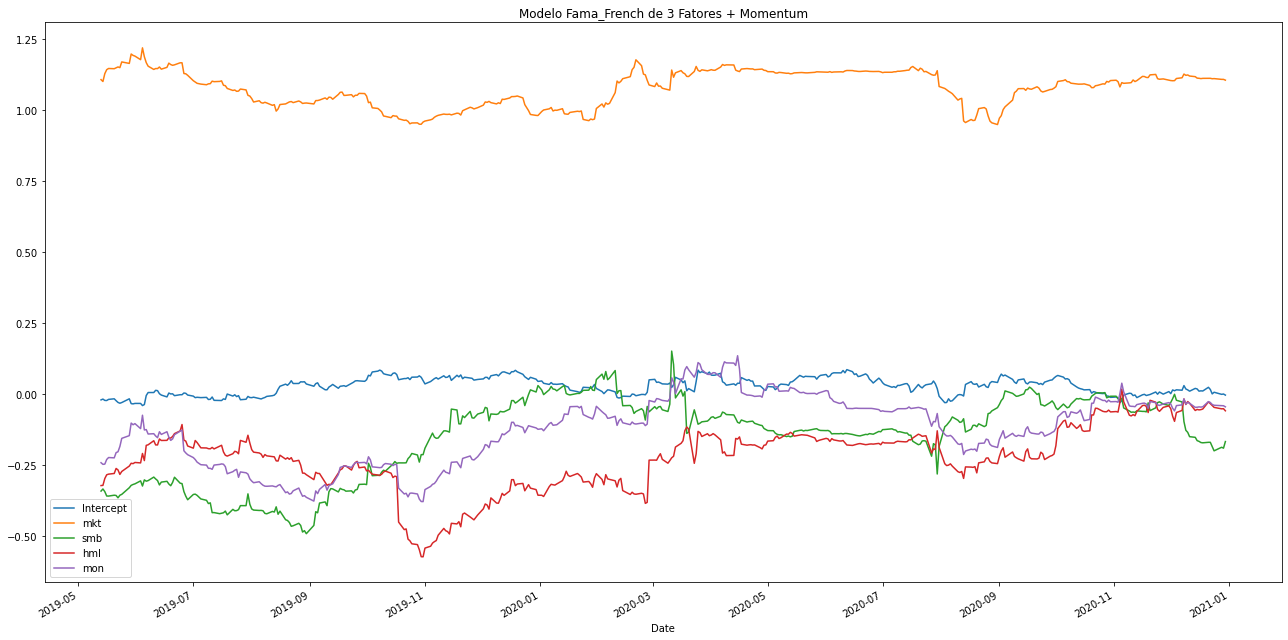

In [25]:
modelo = 'portf_rtn ~ mkt + smb + hml+ mon'
results_df = rolling_factor_model(ff_data, 
                                  modelo, 
                                  window_size=90)
results_df.plot(title = 'Modelo Fama_French de 3 Fatores + Momentum',figsize=(18,9))

plt.tight_layout()
plt.show()